# phys3 properties

In [9]:
import os, sys
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/'

# filename of interest
file = 'im_phys3_std_medr_medv_noiseless.image.fits'

p3noisy = 'phys3_std_medr_medv_noisy.uvfits'
p3noiseless = 'phys3_std_medr_medv_noiseless.uvfits'

# download site
site = 'https://www.cfa.harvard.edu/~sandrews/data/'

# grab file
if not os.path.exists(wdir + 'fake_data/img_fits/' + file):
    urllib.request.urlretrieve(site+file, wdir + 'fake_data/img_fits/' + file)
    print('Downloading FITS image...')
if not os.path.exists(wdir + 'fake_data/sim_uvfits/' + p3noisy):
    print('Downloading UVFITS...')
    urllib.request.urlretrieve(site+p3noisy, wdir + 'fake_data/sim_uvfits/' + p3noisy)
    print('Downloaded %s' % (p3noisy))
if not os.path.exists(wdir + 'fake_data/sim_uvfits/' + p3noiseless):
    print('Downloading UVFITS...')
    urllib.request.urlretrieve(site+p3noiseless, wdir + 'fake_data/sim_uvfits/' + p3noiseless)
    print('Downloaded %s' % (p3noiseless))

In [10]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/fake_data/img_fits/'

# load the cube and "header" information
data = fits.open(wdir + file)
cube = np.squeeze(data[0].data)
hdr = data[0].header

print(cube.shape)

(121, 512, 512)


In [11]:
# SPATIAL
# number of pixels in each dimensions
nRA, nDEC = hdr['NAXIS1'], hdr['NAXIS2']

# convert pixel indices to RA, DEC (each in units of degrees on the sky)
RA = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(nRA) - (hdr['CRPIX1'] - 1))
DEC = hdr['CRVAL2'] + hdr['CDELT2'] * (np.arange(nDEC) - (hdr['CRPIX2'] - 1))

# convert these to offsets from the image center, in **arcseconds** units (1 degree = 3600 arcseconds)
RAo, DECo = 3600 * (RA - hdr['CRVAL1']), 3600 * (DEC - hdr['CRVAL2'])

# in some cases, the emission center (= location of star, which we don't see in these data) is offset from the 
# image center; we can correct for that to have a coordinate frame on the sky, centered on the star position
# (note: these shifts are quite small in this case, but for clarity, here's how you do it)
offRA, offDEC = 0.00, 0.00    # the offsets (measured elsewhere)
dRAo, dDECo = RAo - offRA, DECo - offDEC

# now create a 2-D grid of RA and DEC offsets (relative to emission center) for each pixel in the cube
dRA, dDEC = np.meshgrid(dRAo, dDECo)

# SPECTRAL
# number of channels
nchan = hdr['NAXIS3']

# convert channel indices to frequencies (in units of Hz)
freq = hdr['CRVAL3'] + hdr['CDELT3'] * (np.arange(nchan) - (hdr['CRPIX3'] - 1))

# use the Doppler formula to calculate the corresponding velocities (in units of km/s)
c_ = 2.99792e5       # speed of light in km/s
freq0 = 230.538e9    # rest frequency of CO J=2-1 line in Hz
vel = c_ * (1. - freq / freq0)

In [27]:
# sys.path.append("/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn")
# from brighttemp import brighttemp as bt

# bmaj = hdr['BMAJ'] * 3600
# bmin = hdr['BMIN'] * 3600
# #k_cube = bt(cube[ch_idx,:,:], (bmaj, bmin), freq0) #converted cube, in K units
# k_cube = bt(cube, (bmaj, bmin), freq0) #converted cube, in K units
# print(np.amin(k_cube))
# print(np.amax(k_cube))
print(np.amin(1e3*cube))
print(np.amax(1e3*cube))

-3.2841384
292.51834


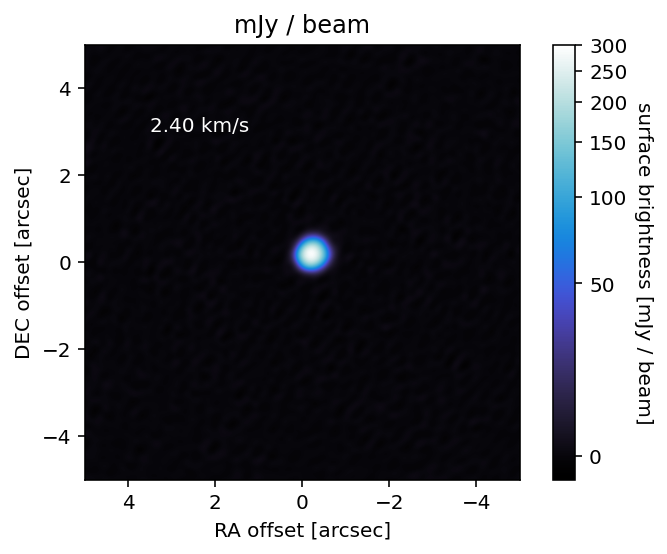

In [28]:
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize, LinearStretch)    # image visualization functions

# channel index to plot
ch_idx = 50

# define the full image boundaries with a list of the min/max RA and DEC offsets
# (note the reverse ordering for RA, since this is plotted with E to the left)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [5, -5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-5, 5]

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -5, 300   # these are in Jy/beam units [K units (0-100)]
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e3*cube[ch_idx,:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('mJy / beam')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# annotate with the velocity
vel_str = '%.2f km/s' % vel[ch_idx]
ax.text(3.5, 3.0, vel_str, color='w');

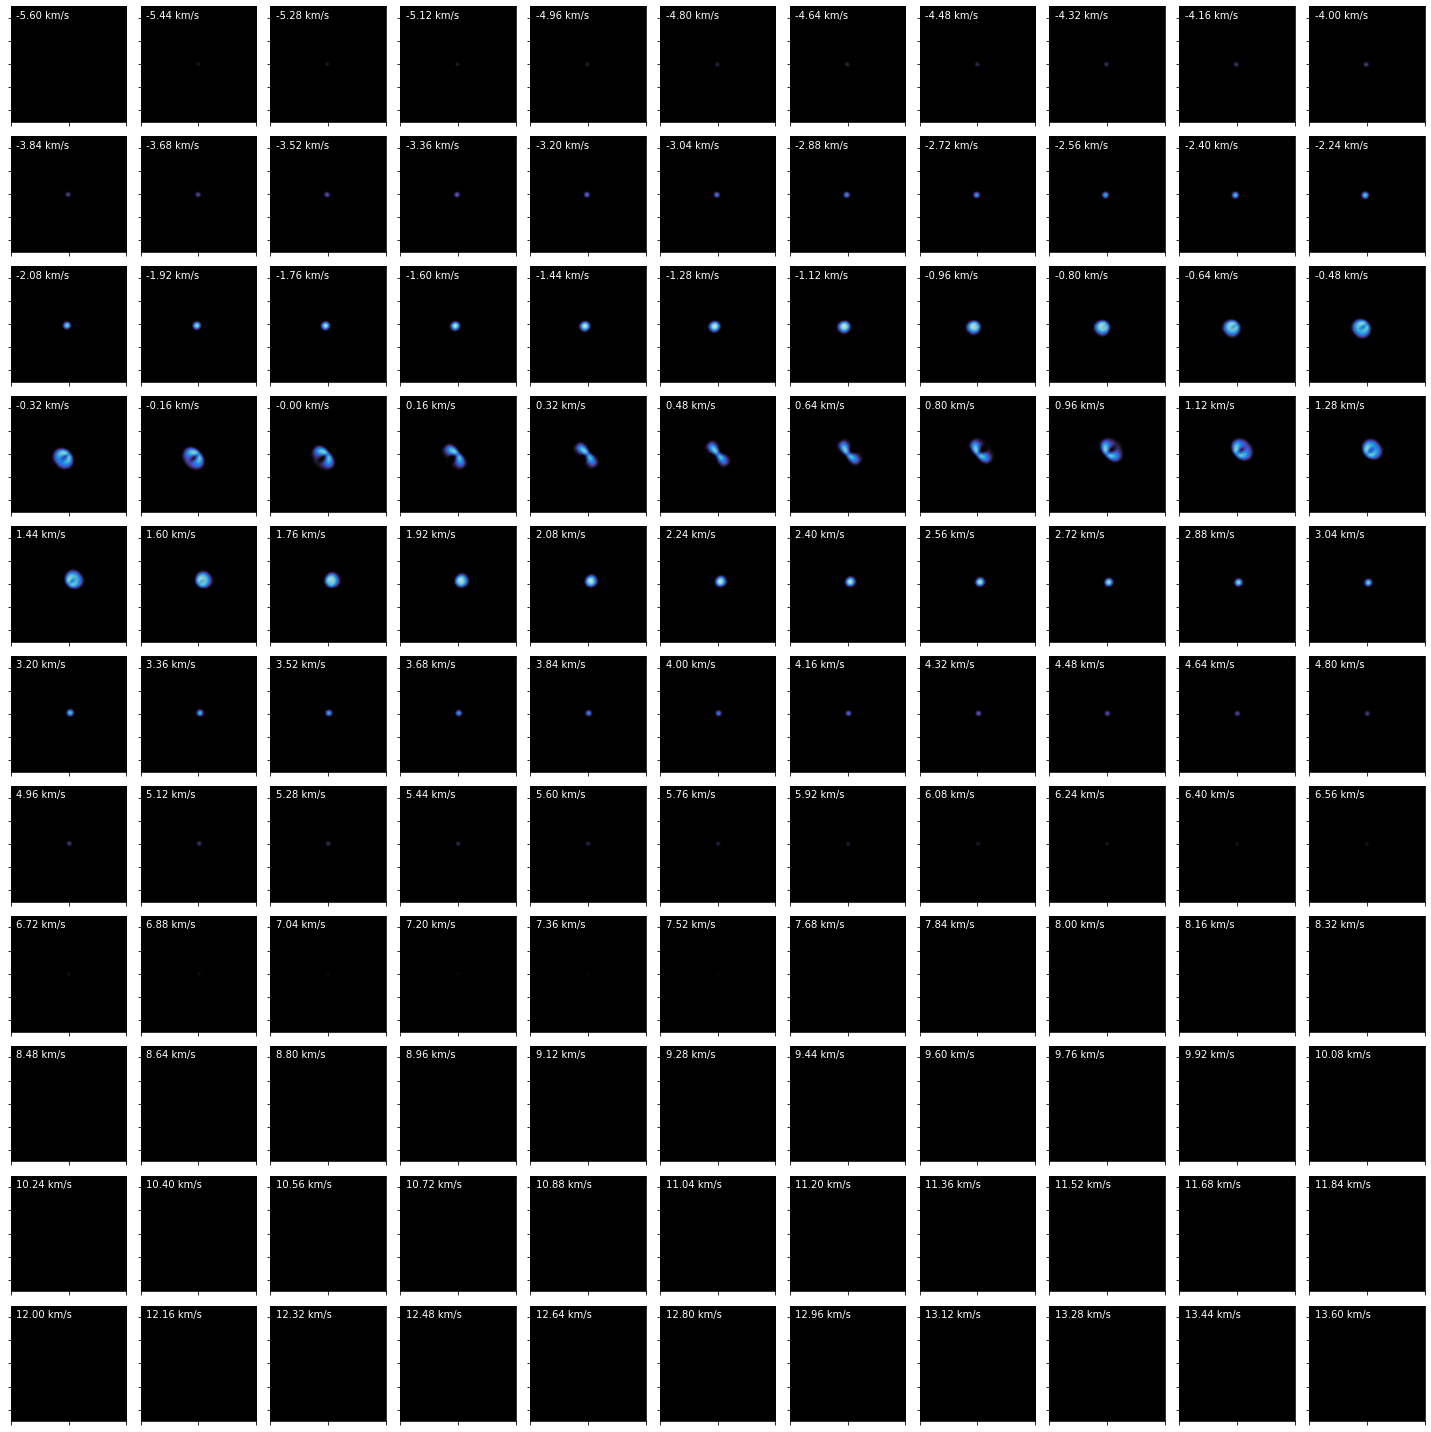

In [36]:
import matplotlib.gridspec as gridspec

n=11 # number of columns
vch_idx = np.arange(n**2) # number of channels cube.shape[0]
axes = ['ax'+ str(i) for i in range(n**2)] # labels for axes

c = np.arange(n)
r = np.arange(n)
cols, rows = np.meshgrid(c, r)
points = np.column_stack((np.ravel(rows), np.ravel(cols)))

fig = plt.figure(tight_layout=True, figsize=(22,22))
spec = gridspec.GridSpec(ncols=n, nrows=n, figure=fig)

for i in range(len(axes)):  
    axes[i] = fig.add_subplot(spec[points[i][0], points[i][1]])
    axes[i].imshow(k_cube[vch_idx[i], :, :], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
    axes[i].set_xlim(dRA_lims)
    axes[i].set_ylim(dDEC_lims)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)        

    # annotate with the velocity
    vel_str = '%.2f km/s' % vel[vch_idx[i]]
    axes[i].text(4.5, 4.0, vel_str, color='w');

# GoFish

In [69]:
from gofish import imagecube
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/fake_data/img_fits/'
cube = imagecube(wdir +file, FOV=4.0)

In [70]:
inc = 40.0
PA = 130.0
mstar = 0.7
dist = 150.0

9.823187112808228


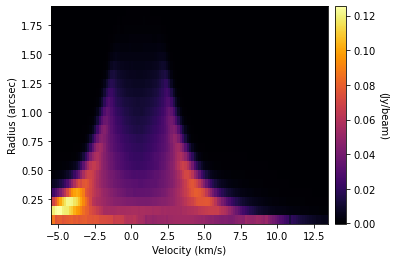

In [53]:
t0 = time.time()
cube.plot_teardrop(inc=inc, PA=PA, mstar=mstar, dist=dist)
t1 = time.time()
print(t1-t0)

In [1]:
# Trace evaluation

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
from matplotlib import pyplot as plt
import numpy as np
import pygtc
import os, sys
import matplotlib.pyplot as plt
import emcee
import copy

lbls = [r'$i$', r'$PA$', r'$M$', r'$r_l$', r'$z0$', r'$z_{\psi}$', r'$Tb_{0}$', r'$Tb_q$', r'$T_{\rm{back}}$', r'$dV_{0}$', r'$v_{\rm{sys}}$', r'$dx$', r'$dy$']

# scale burn-in
# burnin = 1000

# calculate autocorrelation time as a function of step?
calc_tau = False
Ntau = 100

# load the backend; parse the samples
def make_chain(filename, burnin, stray, trace):
    reader = emcee.backends.HDFBackend(wdir + filename)
    all_samples = reader.get_chain(discard=0, flat=False)
    samples = reader.get_chain(discard=burnin, flat=False)
    log_prob_samples = reader.get_log_prob(discard=burnin, flat=False)
    log_prior_samples = reader.get_blobs(discard=burnin, flat=False)
    maxlnprob = np.max(reader.get_log_prob(discard=0, flat=False))
    minlnprob = np.min(reader.get_log_prob(discard=0, flat=False))
    nsteps, nwalk, ndim = samples.shape[0], samples.shape[1], samples.shape[2]
    
    # finding that stray walker
    if stray == True:
        prob = np.array(reader.get_log_prob(discard=burnin, flat=False))
        prob_mean = np.mean(prob, axis=0) # finds mean prob per walker
        rm_idx = np.where(prob_mean == np.min(prob_mean)) # gives index of lowest mean probability walker
        new_samp = np.delete(samples, rm_idx, axis=1) # removes lowest mean probability walker from samples
        nsteps, nwalk, ndim = new_samp.shape[0], new_samp.shape[1], new_samp.shape[2]
        #print(nsteps, nwalk, ndim)
    
        if trace == True:
            # for trace plot (disable return)
            for i in range(ndim):
                fig = plt.figure(figsize=(5, 5))
                plt.plot(np.arange(nsteps), new_samp[:,:,i], alpha=0.3)
                #plt.plot([0, nsteps], [theta[i], theta[i]], 'r', lw=2)
                plt.ylabel(lbls[i], fontsize=12)
                plt.title('Trace %s' % lbls[i])
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.show()
        
        else:     
            # corner plot to view covariances
            levs = 1. - np.exp(-0.5*(np.arange(3)+1)**2)
            flat_chain = new_samp.reshape(-1, ndim)
            return(flat_chain)
    
    
    else:
        if trace == True:
        # for trace plot (disable return)
            for i in range(ndim):
                fig = plt.figure(figsize=(5, 5))
                plt.plot(np.arange(nsteps), samples[:,:,i], alpha=0.3)
                #plt.plot([0, nsteps], [theta[i], theta[i]], 'r', lw=2)
                plt.ylabel(lbls[i], fontsize=12)
                plt.title('Trace %s' % lbls[i])
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.show()
        else:
            flat_chain = samples.reshape(-1, ndim)
            return(flat_chain)

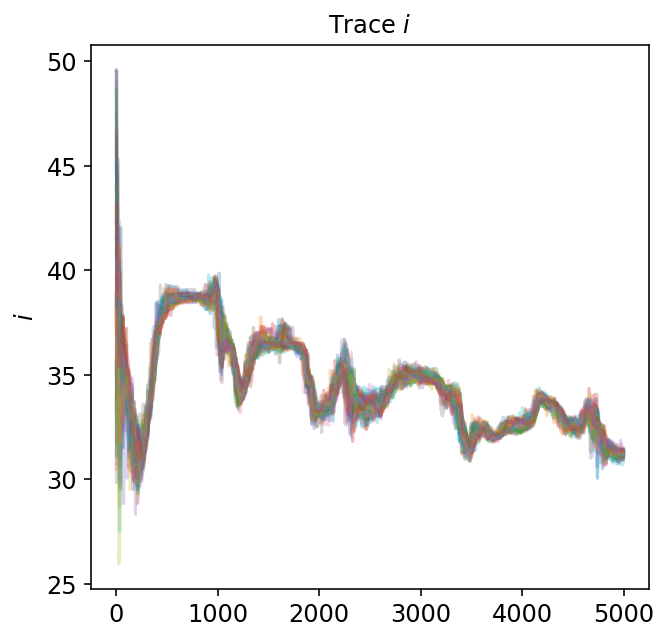

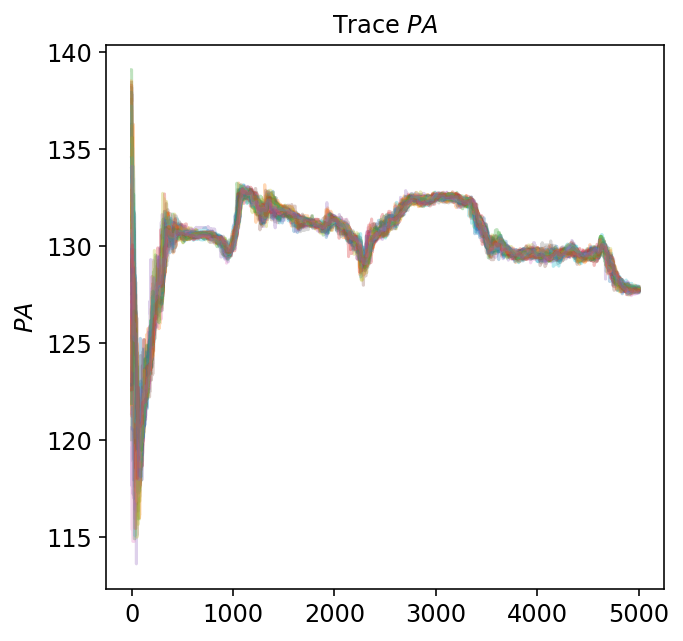

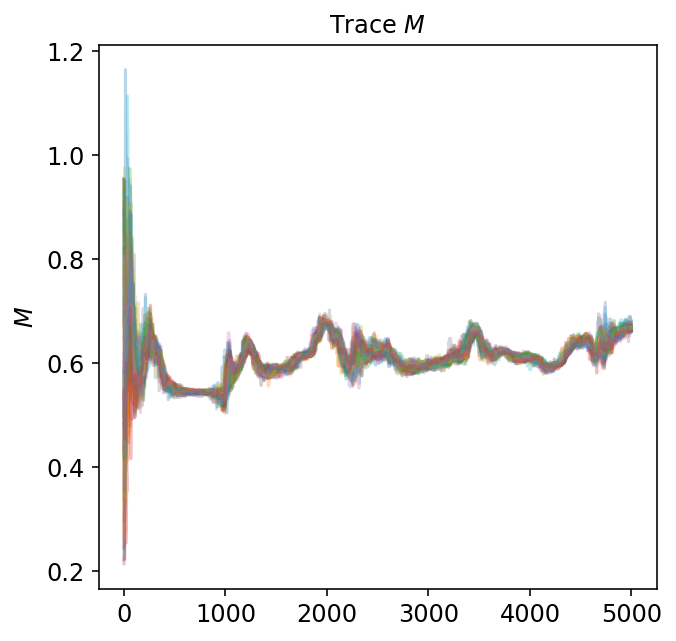

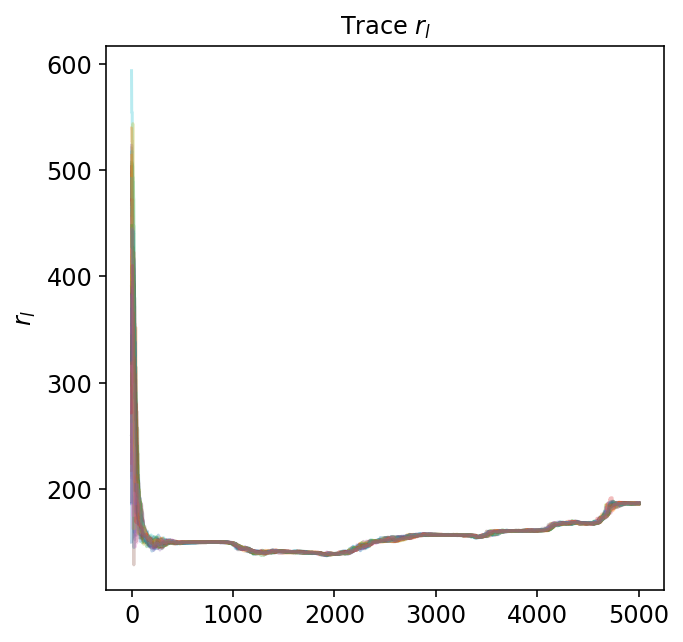

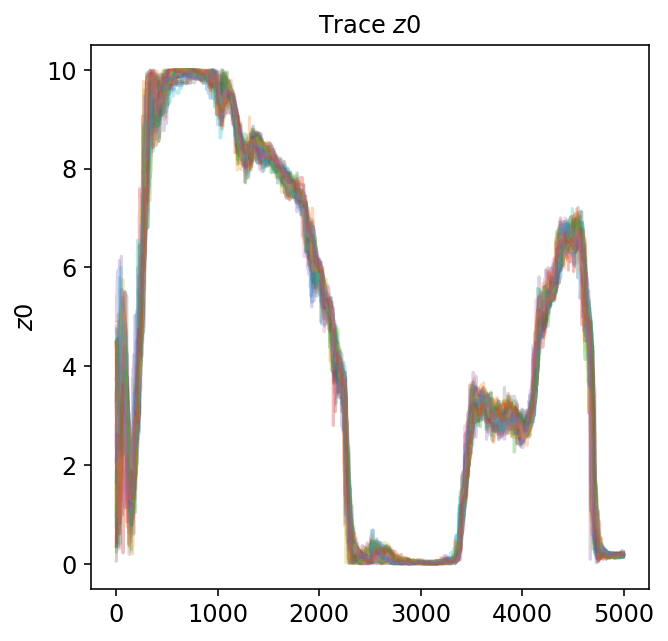

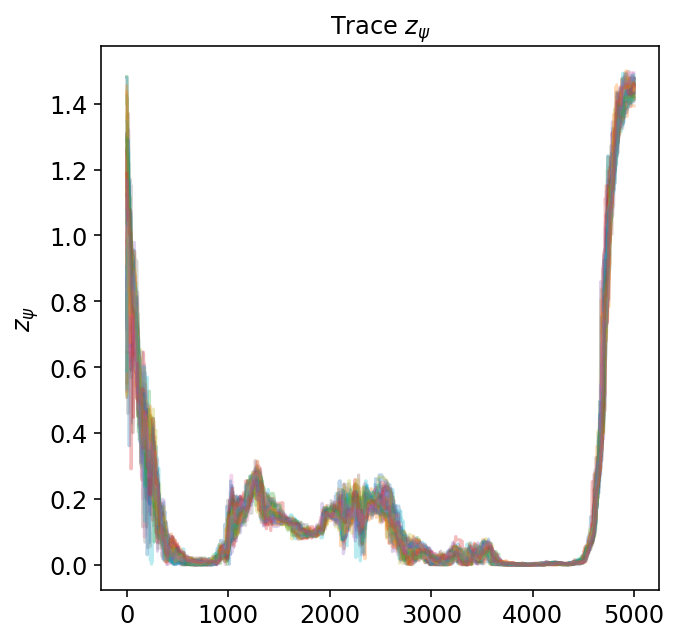

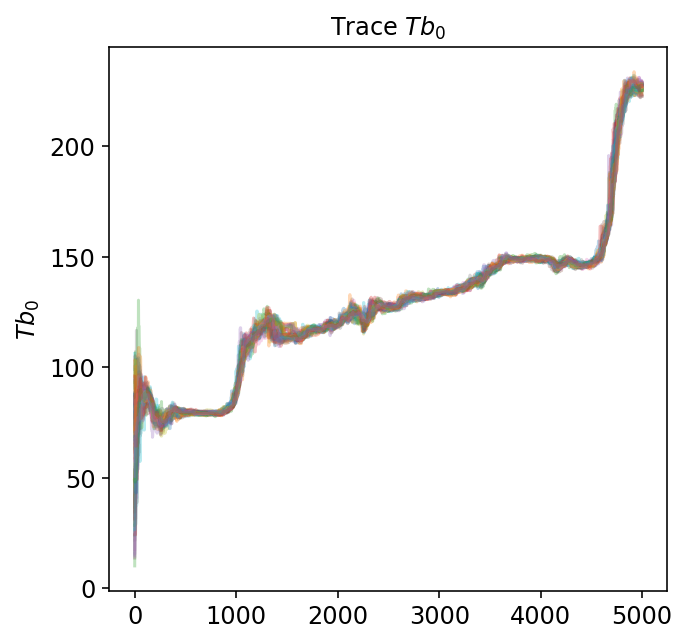

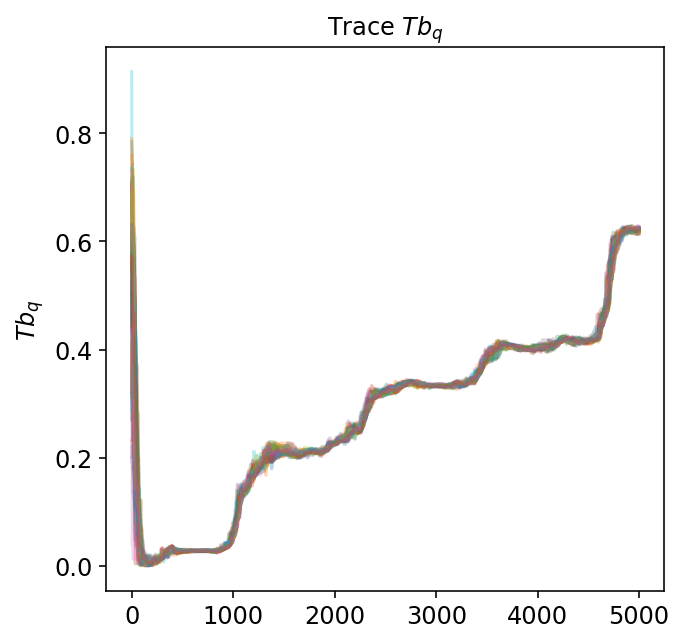

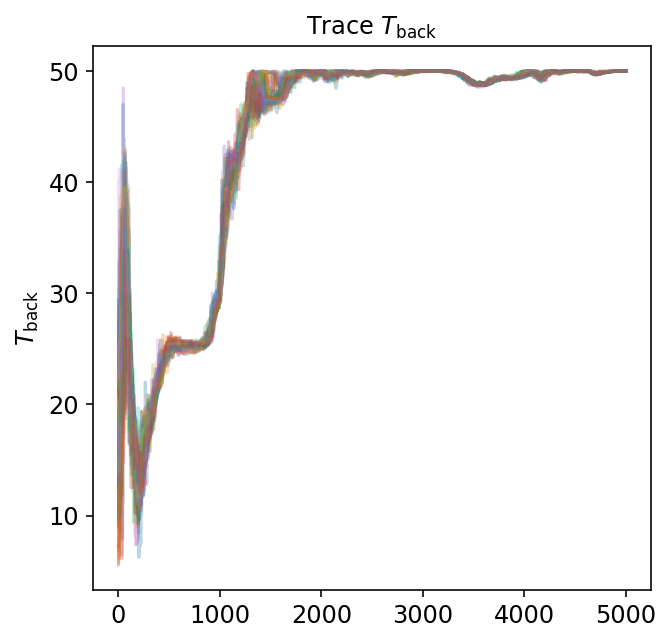

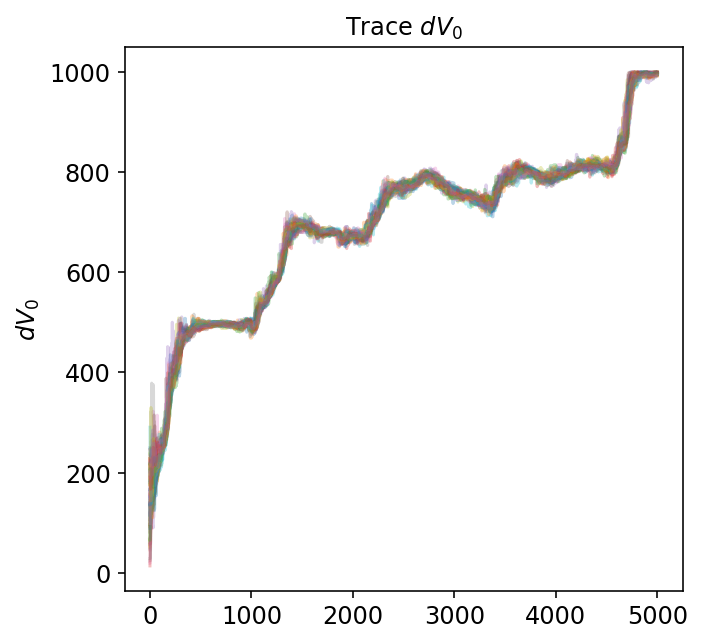

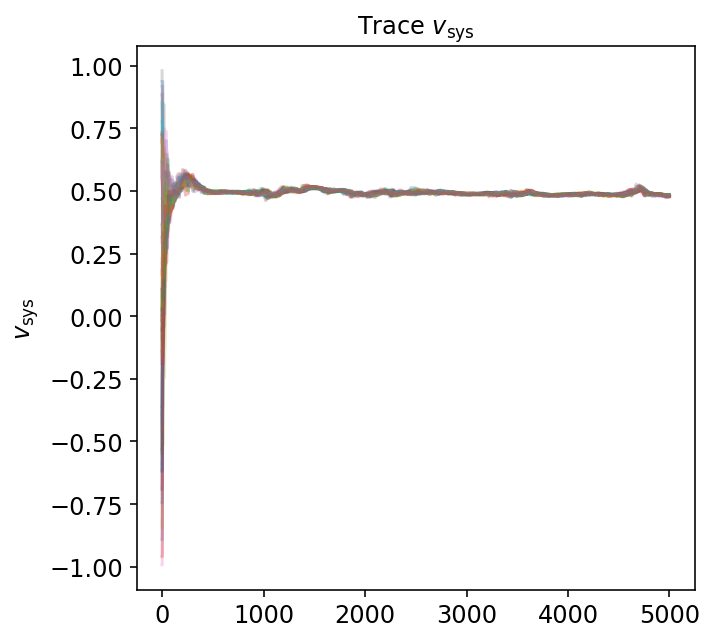

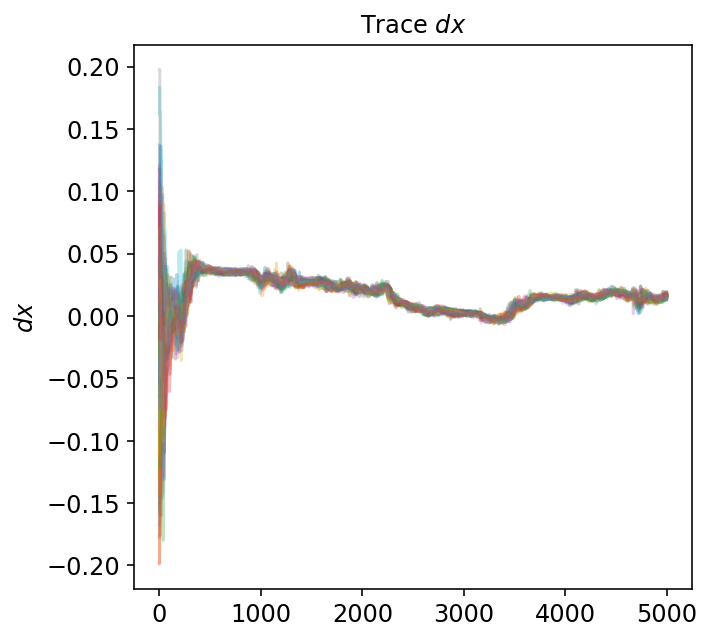

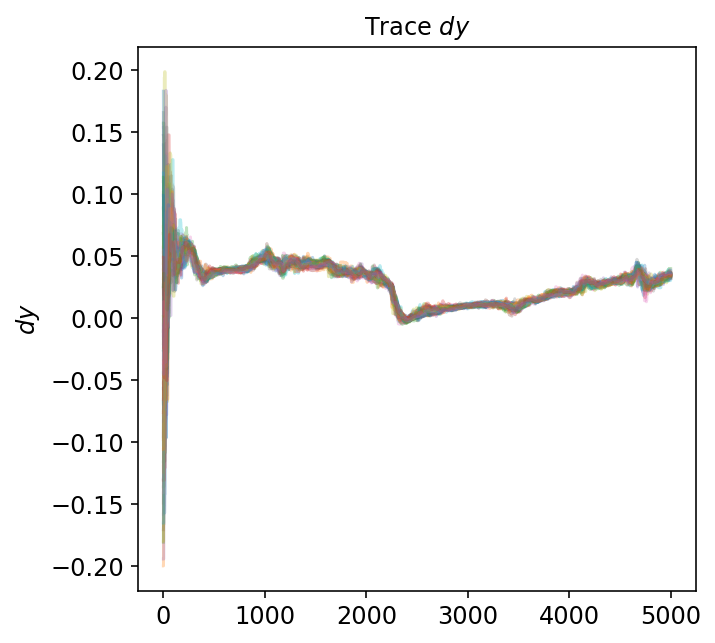

In [7]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/posteriors/'
phys3_nsls = make_chain('phys3_std_medr_medv_noiseless.h5', 0, stray=False, trace=True)

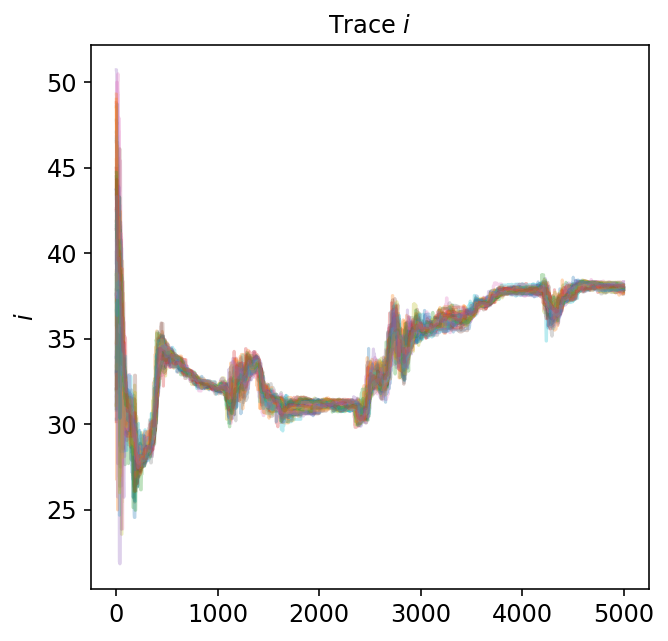

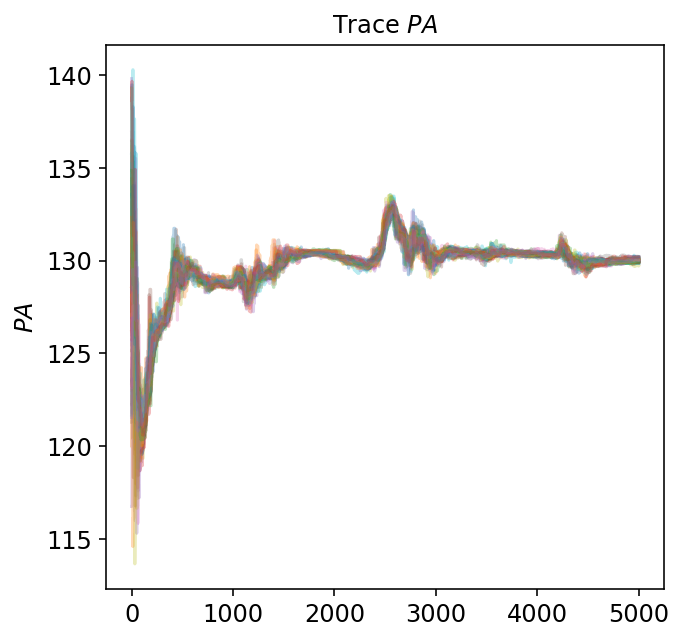

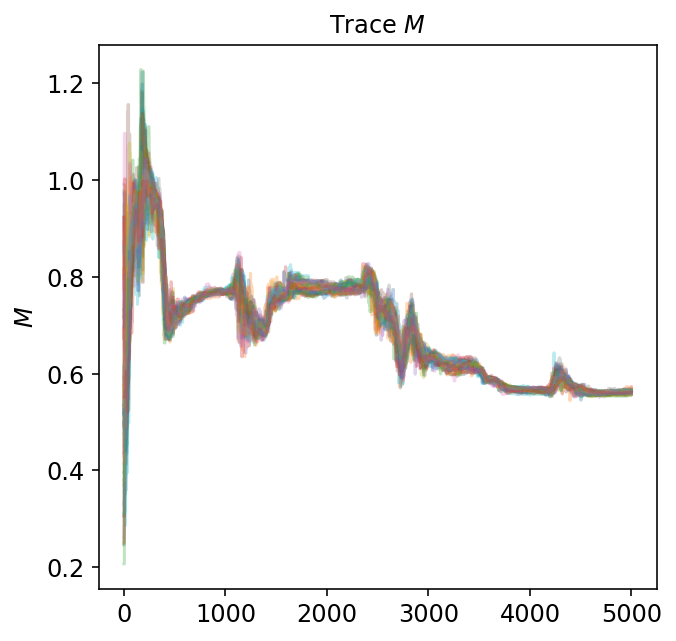

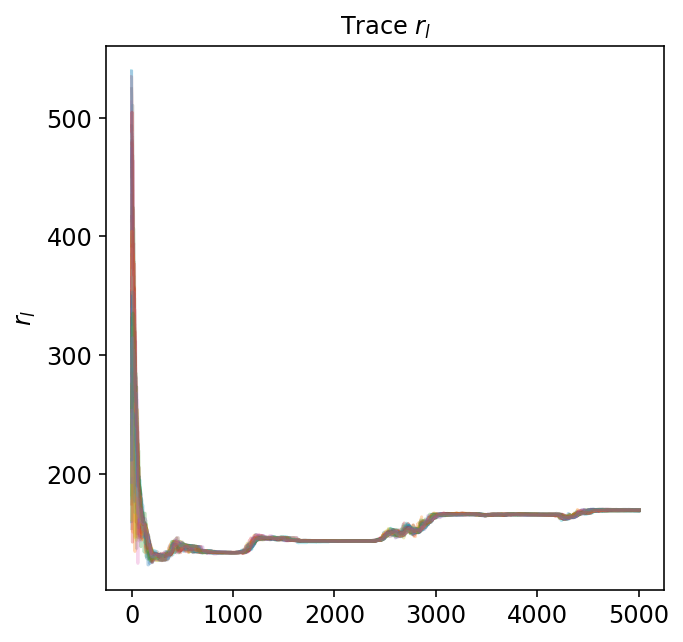

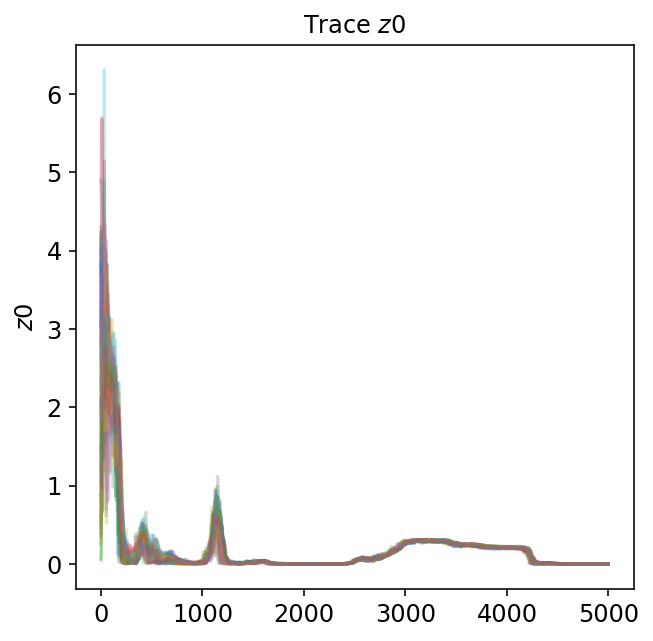

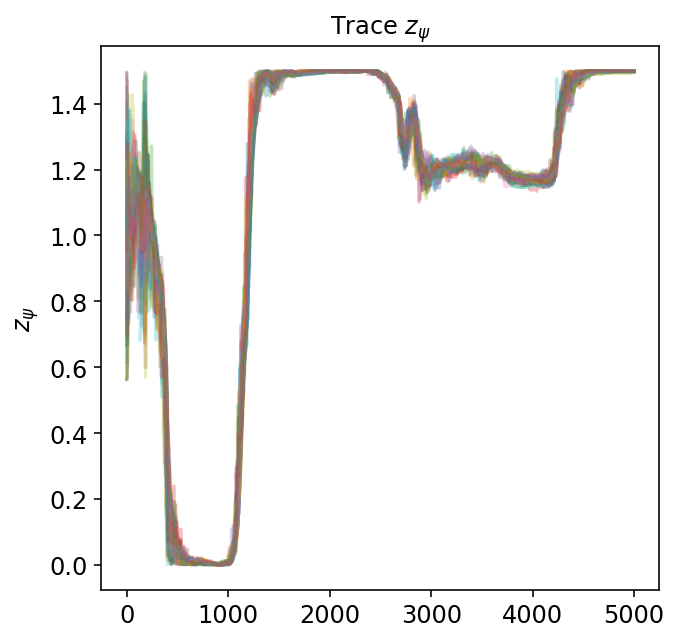

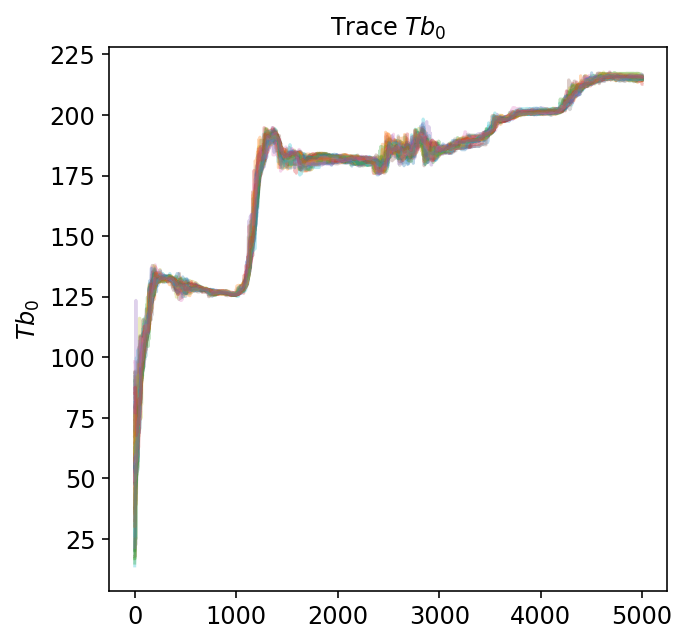

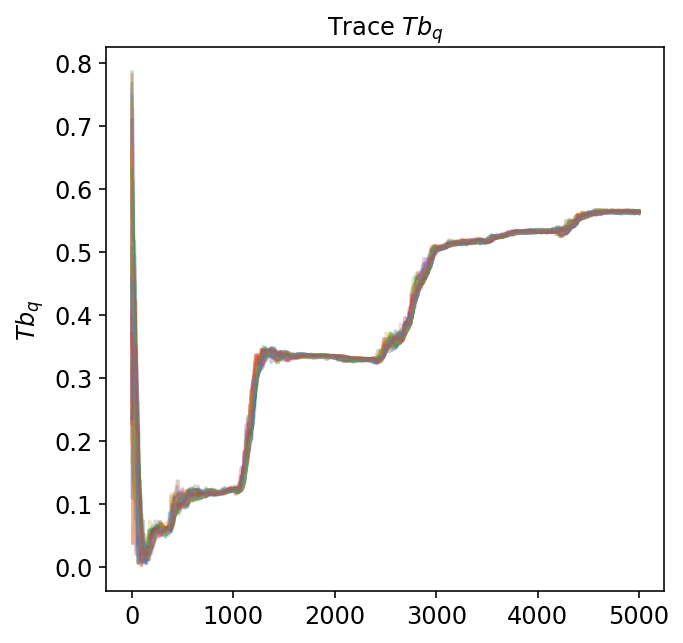

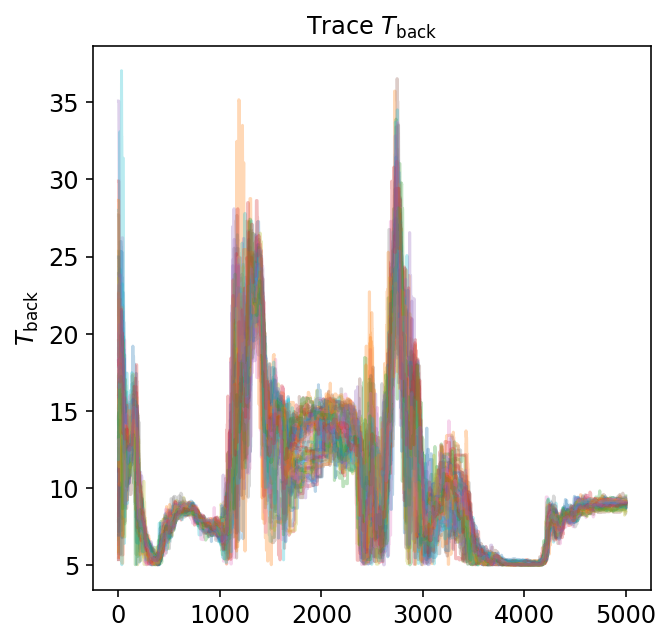

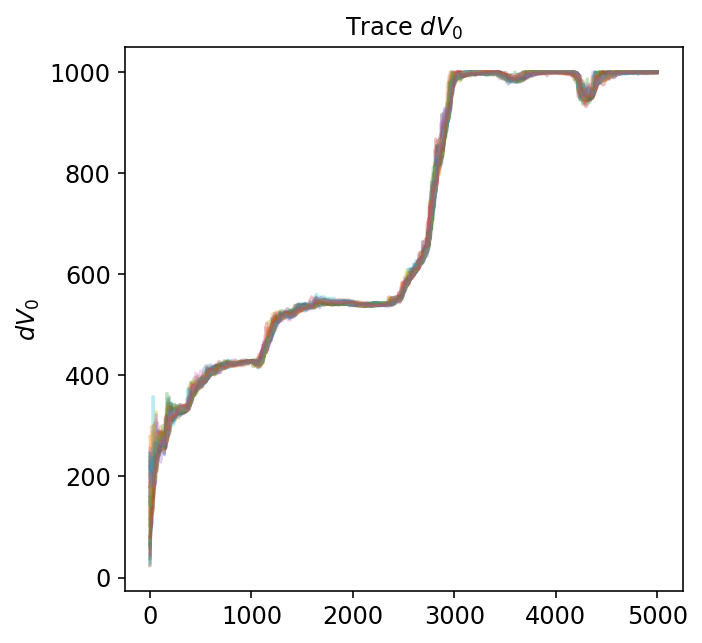

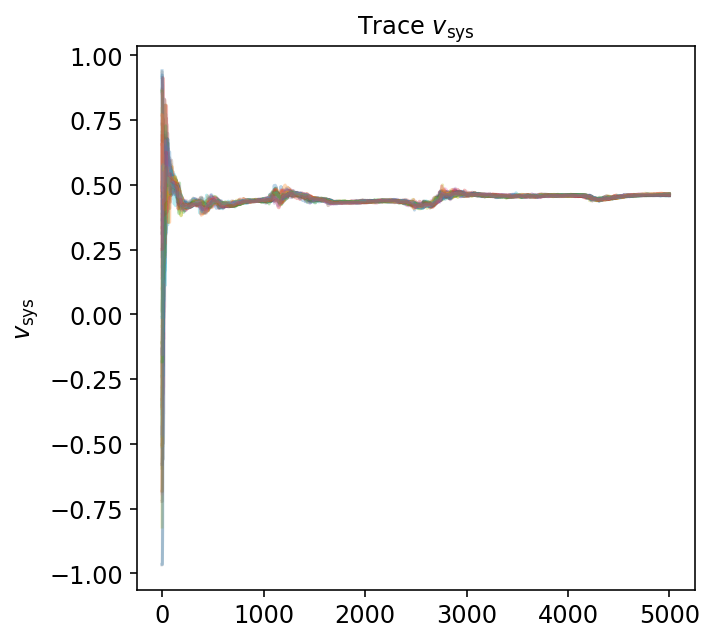

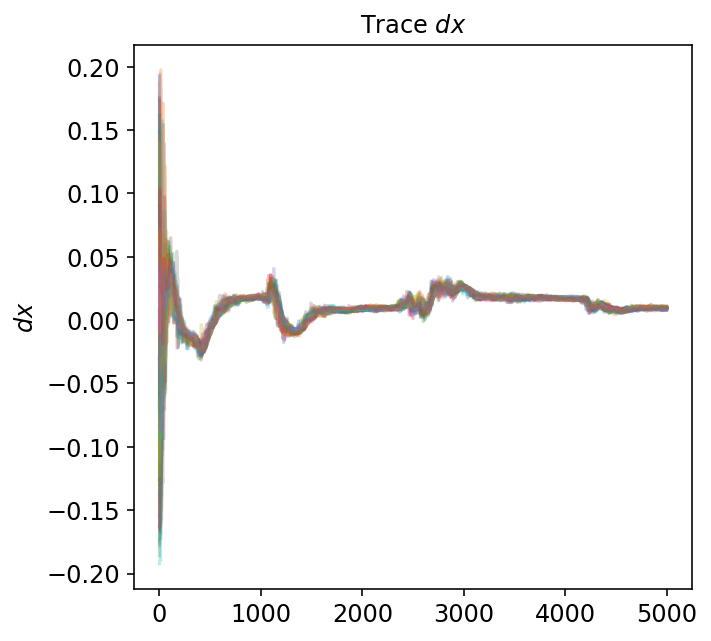

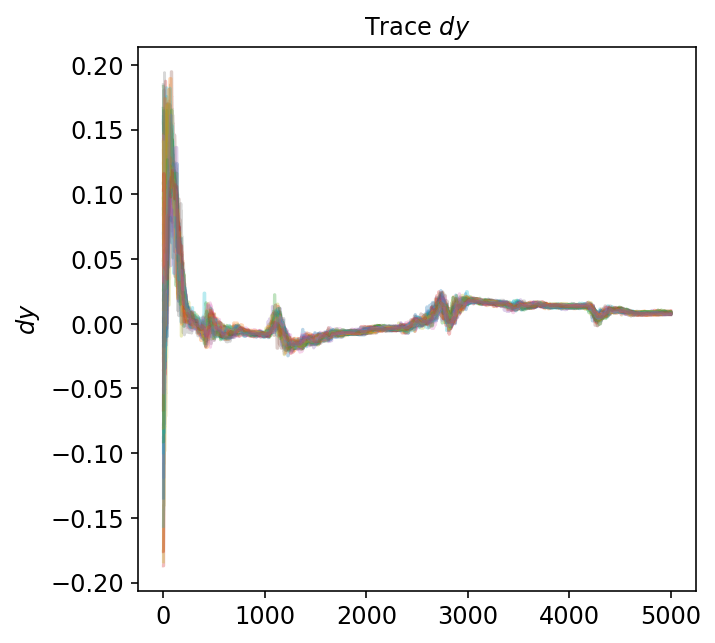

In [67]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/posteriors/'
phys3_nsls1 = make_chain('phys3_std_medr_medv_noiseless2.h5', 0, stray=False, trace=True)

In [48]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/posteriors/'
phys3_nsls = make_chain('phys3_std_medr_medv_noiseless2.h5', 1400, stray=False, trace=False)

In [50]:
from post_summary import post_summary
names = ['i', 'PA', 'M', 'r_l', 'z0', 'zpsi', 'Tb0', 'Tbq', 'Tback', 'vsys', 'dx', 'dy']

print('%s best-fit parameters' % (p3noiseless[:-7]))
for j in range(len(names)):
    post_param = post_summary(phys3_nsls[:,j], prec=0.001, mu='peak')
    print('%s = %.2f +%.3f / -%.3f' % (names[j], post_param[0], post_param[1], post_param[2]))
print()

phys3_std_medr_medv_noiseless best-fit parameters
i = 37.88 +0.000 / -6.739
PA = 130.37 +0.177 / -0.440
M = 0.56 +0.210 / -0.000
r_l = 165.77 +1.171 / -22.256
z0 = 0.00 +0.245 / -0.002
zpsi = 1.50 +0.003 / -0.303
Tb0 = 181.82 +30.485 / -0.156
Tbq = 0.33 +0.222 / -0.000
Tback = 8.81 +5.286 / -3.452
vsys = 995.49 +3.422 / -454.496
dx = 0.46 +0.002 / -0.025
dy = 0.01 +0.010 / -0.001



In [62]:
def mk_ch_plots(file, ch_idx, grid): # makes channel plot per channel index
    # load the cube and "header" information
    data = fits.open(wdir + file) # processes cube for phys3 model
    cube = np.squeeze(data[0].data)
    hdr = data[0].header
    
    # SPATIAL
    # number of pixels in each dimensions
    nRA, nDEC = hdr['NAXIS1'], hdr['NAXIS2']

    # convert pixel indices to RA, DEC (each in units of degrees on the sky)
    RA = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(nRA) - (hdr['CRPIX1'] - 1))
    DEC = hdr['CRVAL2'] + hdr['CDELT2'] * (np.arange(nDEC) - (hdr['CRPIX2'] - 1))

    # convert these to offsets from the image center, in **arcseconds** units (1 degree = 3600 arcseconds)
    RAo, DECo = 3600 * (RA - hdr['CRVAL1']), 3600 * (DEC - hdr['CRVAL2'])

    offRA, offDEC = 0.02, 0.02    # the offsets (measured elsewhere)
    dRAo, dDECo = RAo - offRA, DECo - offDEC

    # now create a 2-D grid of RA and DEC offsets (relative to emission center) for each pixel in the cube
    dRA, dDEC = np.meshgrid(dRAo, dDECo)

    # SPECTRAL
    # number of channels
    nchan = hdr['NAXIS3']

    # convert channel indices to frequencies (in units of Hz)
    freq = hdr['CRVAL3'] + hdr['CDELT3'] * (np.arange(nchan) - (hdr['CRPIX3'] - 1))

    # use the Doppler formula to calculate the corresponding velocities (in units of km/s)
    c_ = 2.99792e5       # speed of light in km/s
    freq0 = 230.538e9    # rest frequency of CO J=2-1 line in Hz
    vel = c_ * (1. - freq / freq0)

    # brighttemp processing
    sys.path.append("/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn")
    from brighttemp import brighttemp as bt
    bmaj = hdr['BMAJ'] * 3600
    bmin = hdr['BMIN'] * 3600
    #k_cube = bt(cube[ch_idx,:,:], (bmaj, bmin), freq0) #converted cube, in K units
    k_cube = bt(cube[:,:,:], (bmaj, bmin), freq0) #converted cube, in K units
    
    # PLOTTING
    import cmasher as cmr          # color maps
    from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize, LinearStretch)    # image visualization functions

    # define the full image boundaries with a list of the min/max RA and DEC offsets
    # (note the reverse ordering for RA, since this is plotted with E to the left)
    im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())
    
    # now set the RA and DEC offset ranges you want to show
    dRA_lims  = [5, -5]      # (same reverse ordering to ensure E is to the left)
    dDEC_lims = [-5, 5]
    
    # now define the color-map, intensity limits, and stretch
    cmap = cmr.freeze
    #vmin, vmax = -1, 50   # these are in mJy/beam units
    vmin, vmax = -3, 100   # these are in K units (for btemp)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    
    if grid == True: #toggles grid vs. individual channel map
        import matplotlib.gridspec as gridspec

        n=10 # number of columns
        vch_idx = np.arange(n**2) # number of channels cube.shape[0]
        axes = ['ax'+ str(i) for i in range(n**2)] # labels for axes

        c = np.arange(n)
        r = np.arange(n)
        cols, rows = np.meshgrid(c, r)
        points = np.column_stack((np.ravel(rows), np.ravel(cols)))
    
        fig = plt.figure(tight_layout=True, figsize=(20,20))
        spec = gridspec.GridSpec(ncols=n, nrows=n, figure=fig)

        for i in range(len(axes)):  
            axes[i] = fig.add_subplot(spec[points[i][0], points[i][1]])
            axes[i].imshow(k_cube[vch_idx[i], :, :], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
            axes[i].set_xlim(dRA_lims)
            axes[i].set_ylim(dDEC_lims)
            plt.setp(axes[i].get_xticklabels(), visible=False)
            plt.setp(axes[i].get_yticklabels(), visible=False)        

            # annotate with the velocity
            vel_str = '%.2f km/s' % vel[vch_idx[i]]
            axes[i].text(4.5, 4.0, vel_str, color='w');
    
    if grid == False:
        # set up and plot the image on the specified scale
        fig, ax = plt.subplots()
        #im = ax.imshow(1e3*cube[ch_idx,:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
        im = ax.imshow(k_cube[ch_idx,:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
        ax.set_xlim(dRA_lims)
        ax.set_ylim(dDEC_lims)
        ax.set_xlabel('RA offset [arcsec]')
        ax.set_ylabel('DEC offset [arcsec]')
        ax.set_title(file[:-5])

        # add a scalebar
        cb = plt.colorbar(im, ax=ax, pad=0.05)
        cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

        # annotate with the velocity
        vel_str = '%.2f km/s' % vel[ch_idx]
        ax.text(4.5, 4.0, vel_str, color='w');
        ax.text(4.5, 4.0, vel_str, color='w');
        #plt.savefig('comparison_plots/%s_ch%s.png' % (file, ch_idx), dpi=300)

# model

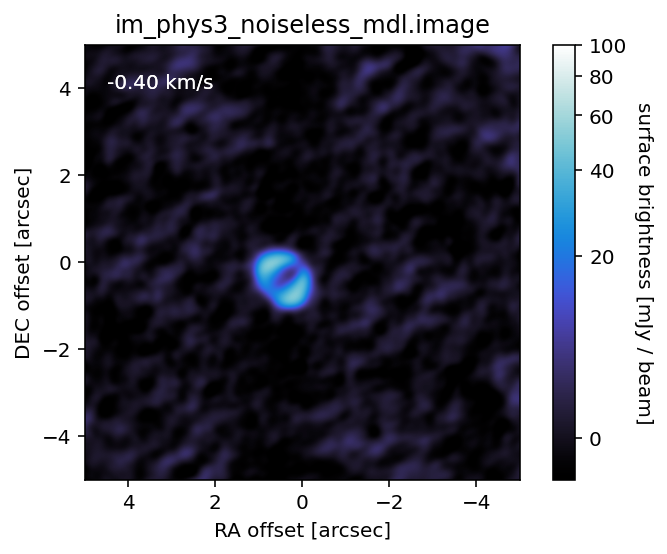

In [63]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/phys3/'
mk_ch_plots('im_phys3_noiseless_mdl.image.fits', 30, grid=False)

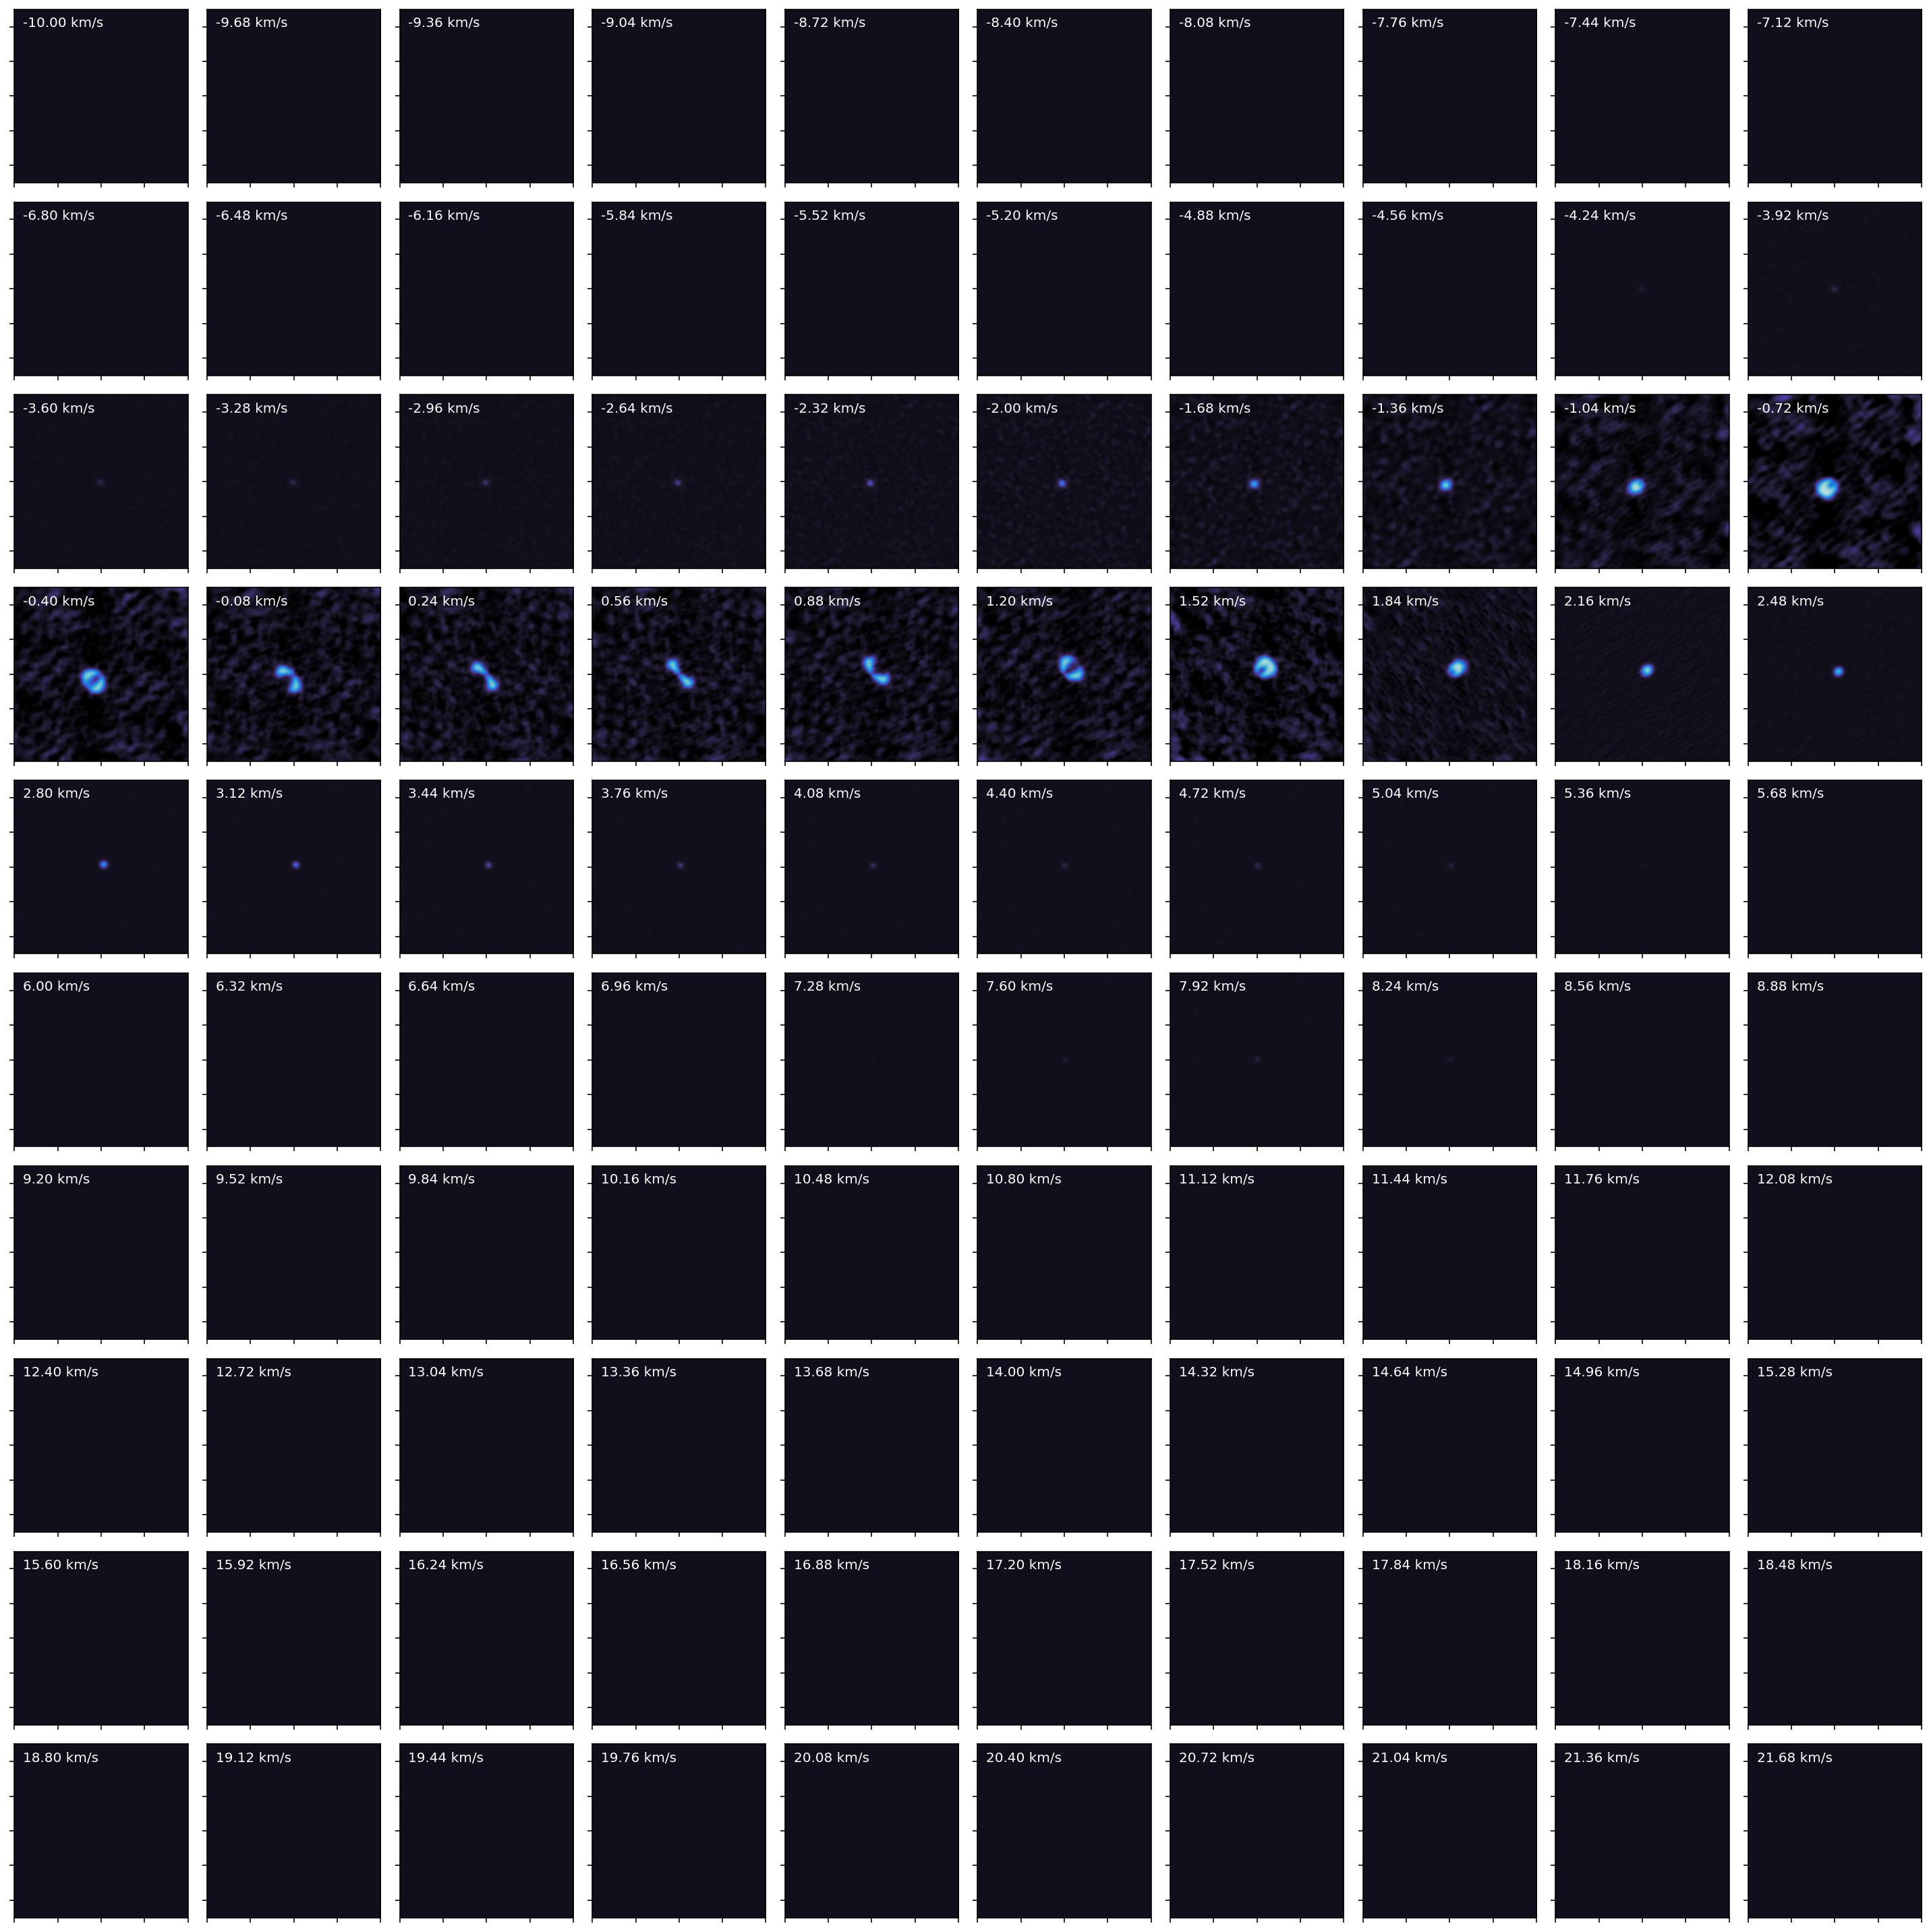

In [64]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/phys3/'
mk_ch_plots('im_phys3_noiseless_mdl.image.fits', 30, grid=True)

# residual

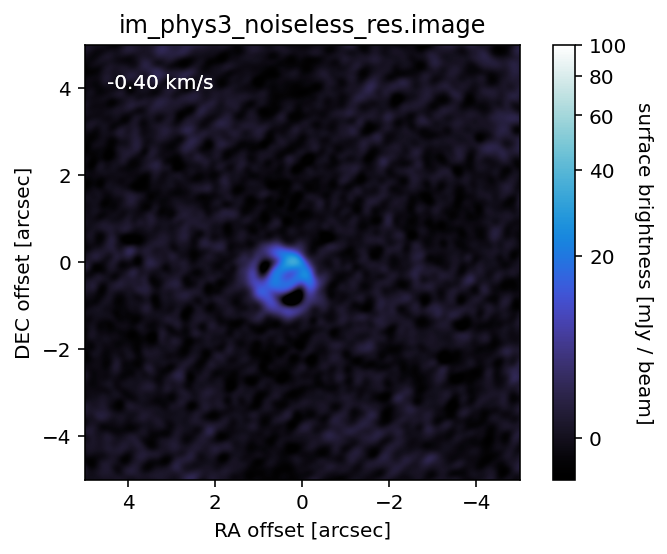

In [65]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/phys3/'
mk_ch_plots('im_phys3_noiseless_res.image.fits', 30, grid=False)

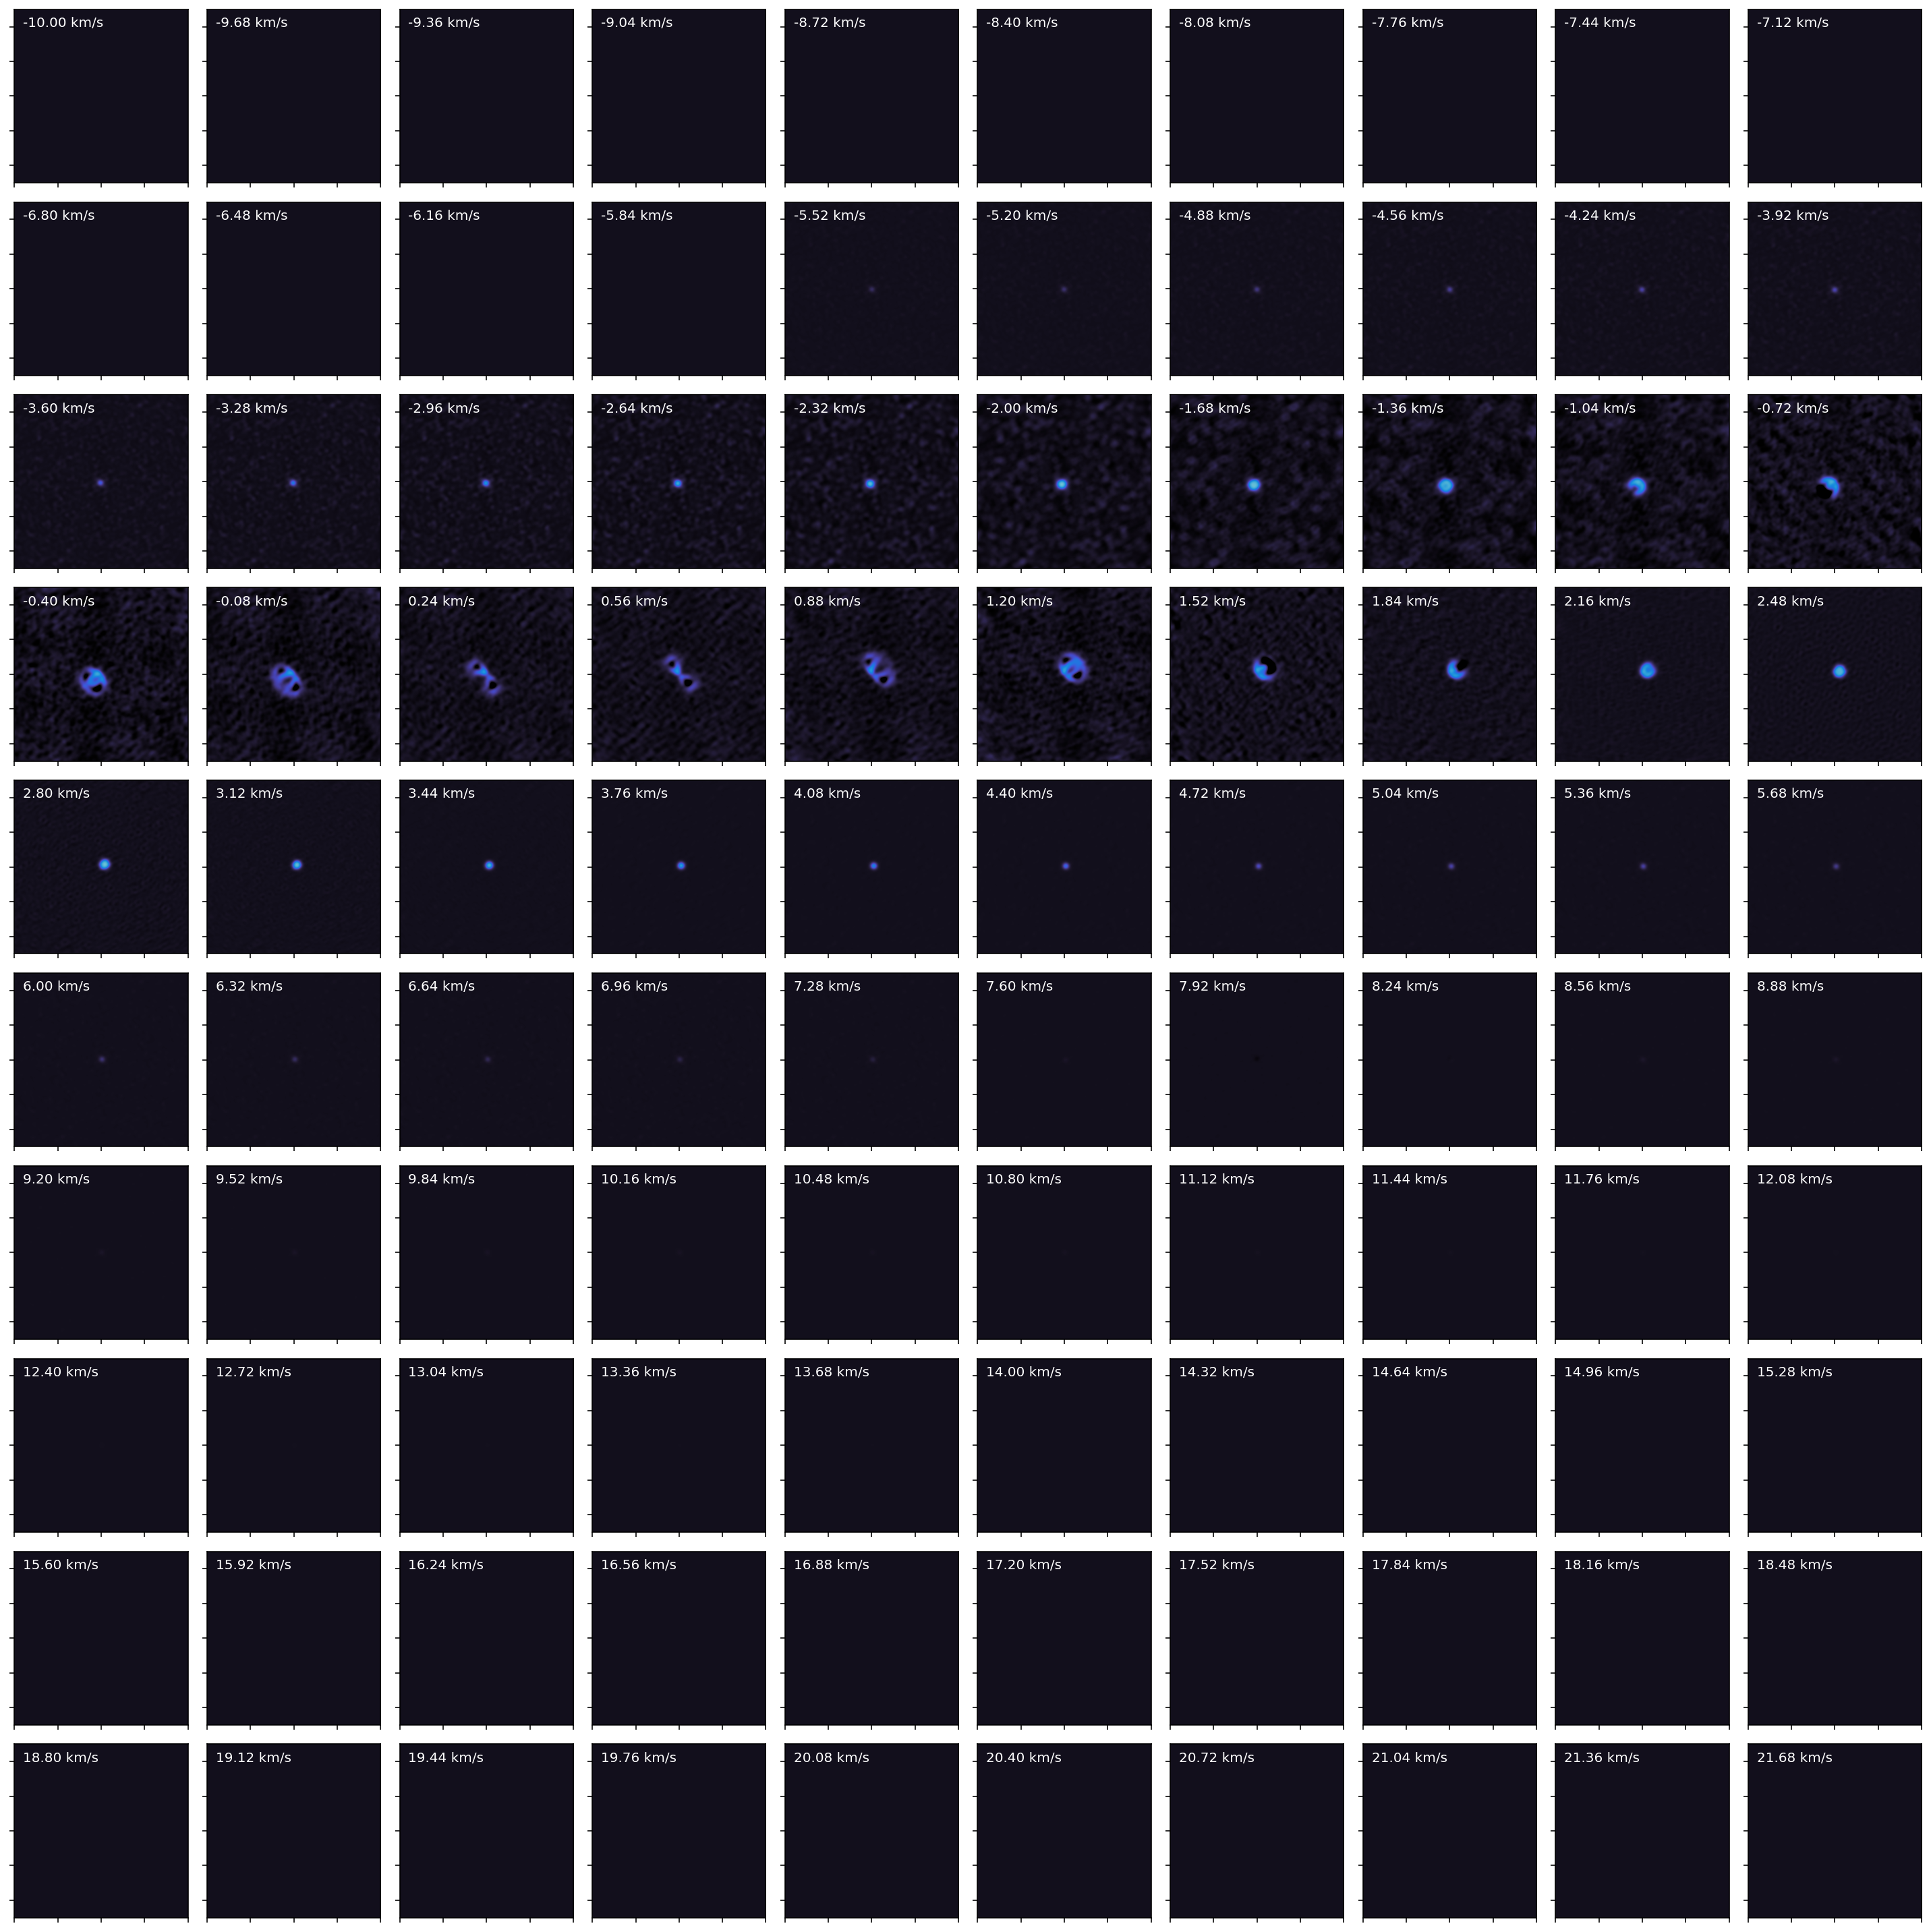

In [66]:
wdir = '/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/phys3/'
mk_ch_plots('im_phys3_noiseless_res.image.fits', 30, grid=True)